In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import h5py
from math import pi

from analysis.config import birds, h5_path_dict, pickle_dir
from analysis.ExpData import ExpData
from analysis.utils import popln_overlap, get_fr

In [26]:
with open(pickle_dir / 'population_patterns.p', 'rb') as f: 
    population_patterns = pickle.load(f)

In [6]:
def plot_overlaps(all_overlaps, title):
    plt.figure()
    plt.hist(all_overlaps, bins=20, alpha=0.4, weights=np.ones(len(all_overlaps)) / len(all_overlaps))
    plt.title(title, fontsize=14)
    plt.ylabel("Proportion of Hops", fontsize=12)
    plt.xlabel("Population Overlap", fontsize=12)
    plt.xlim((0, 1))
    plt.ylim((0, 0.6))
    plt.show()
    print(len(all_overlaps))

# Plot Heatmap of Relative Activation Times

In [30]:
# Collect overlap matrices
all_overlap_matrices = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    noncr_hops = population_patterns[fil_string]['noncr_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']

    for i, c_hop in enumerate(c_hops):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        cache_pattern_mat = hop_patterns[c_hop]
        for j, r_hop in enumerate(r_hops):
            if r_hop <= c_hop: continue
            r_site = exp_data.event_sites[exp_data.retriev_event][j]
            if r_site != c_site: continue
            retriev_pattern_mat = hop_patterns[r_hop]
            overlap_matrix = []
            for retriev_pattern in retriev_pattern_mat.T:
                cache_retriev_overlap = popln_overlap(
                    cache_pattern_mat, retriev_pattern
                    )
                overlap_matrix.append(cache_retriev_overlap)
            overlap_matrix = np.array(overlap_matrix)
            all_overlap_matrices.append(overlap_matrix)
            break
all_overlap_matrices = np.array(all_overlap_matrices)
all_overlap_matrices = np.nanmean(all_overlap_matrices, axis=0)

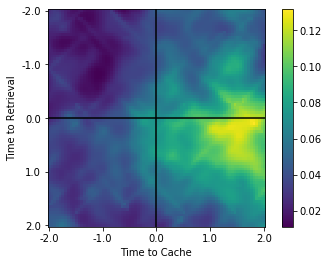

In [31]:
window_size = all_overlap_matrices.shape[0]
window_ticks = np.arange(0, window_size, window_size//4)
plt.imshow(all_overlap_matrices)
plt.yticks(window_ticks, (window_ticks-window_size//2)/20)
plt.xticks(window_ticks, (window_ticks-window_size//2)/20)
plt.axhline(window_size//2, color="black")
plt.axvline(window_size//2, color="black")
plt.ylabel("Time to Retrieval")
plt.xlabel("Time to Cache")
plt.colorbar()
plt.show()

# Redo Analysis for Cache v Navigation

In [28]:
# Collect overlap matrices
all_overlap_matrices = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    noncr_hops = population_patterns[fil_string]['noncr_hops']
    fr = population_patterns[fil_string]['fr']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    for i, c_hop in enumerate(c_hops):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        cache_pattern_mat = hop_patterns[c_hop]
        for j, noncr_hop in enumerate(noncr_hops):
            noncr_site = exp_data.hop_end_wedges[noncr_hop]
            if noncr_site != c_site: continue
            navig_pattern_mat = hop_patterns[noncr_hop]
            overlap_matrix = []
            for navig_pattern in navig_pattern_mat.T:
                cache_navig_overlap = popln_overlap(
                    cache_pattern_mat, navig_pattern
                    )
                overlap_matrix.append(cache_navig_overlap)
            overlap_matrix = np.array(overlap_matrix)
            all_overlap_matrices.append(overlap_matrix)
all_overlap_matrices = np.array(all_overlap_matrices)
all_overlap_matrices = np.nanmean(all_overlap_matrices, axis=0)

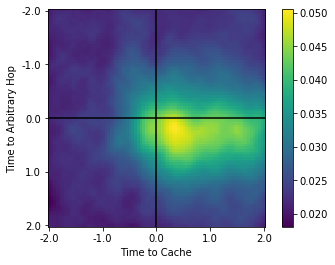

In [29]:
window_size = all_overlap_matrices.shape[0]
window_ticks = np.arange(0, window_size, window_size//4)
plt.imshow(all_overlap_matrices)
plt.yticks(window_ticks, (window_ticks-window_size//2)/20)
plt.xticks(window_ticks, (window_ticks-window_size//2)/20)
plt.axhline(window_size//2, color="black")
plt.axvline(window_size//2, color="black")
plt.ylabel("Time to Arbitrary Hop")
plt.xlabel("Time to Cache")
plt.colorbar()
plt.show()

# Redo Analysis for Cache Reactivation vs Navigation
Heatmap will be aligned to maximal episode reactivation frame as opposed to the hop into a site

In [22]:
window = 40
fr_smoothing_window = int(20*0.25)
l2_normalization = True

In [7]:
# Collect reactivation times
all_reactiv_times = {} # Contains (c, r) pairs of frametimes
all_reactiv_sites = {}
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    noncr_hops = population_patterns[fil_string]['noncr_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    hop_times = population_patterns[fil_string]['hop_times']
    all_reactiv_times[fil_string] = []
    all_reactiv_sites[fil_string] = []

    for i, c_hop in enumerate(c_hops):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        cache_pattern_mat = hop_patterns[c_hop]
        for j, r_hop in enumerate(r_hops):
            if r_hop <= c_hop: continue
            r_site = exp_data.event_sites[exp_data.retriev_event][j]
            if r_site != c_site: continue
            retriev_pattern_mat = hop_patterns[r_hop]
            overlaps = []
            reactiv_times = []
            for r_frame, retriev_pattern in zip(hop_times[r_hop], retriev_pattern_mat.T):
                cache_retriev_overlap = popln_overlap(
                    cache_pattern_mat, retriev_pattern
                    )
                max_val = np.nanmax(cache_retriev_overlap)
                if not np.isnan(max_val):
                    overlaps.append(max_val)
                    c_frame = hop_times[c_hop][np.nanargmax(cache_retriev_overlap)]
                    reactiv_times.append([c_frame, r_frame])
            if len(overlaps) > 0:
                max_val = np.nanmax(overlaps)
                max_idx = np.nanargmax(overlaps)
                all_reactiv_times[fil_string].append(reactiv_times[max_idx])
                all_reactiv_sites[fil_string].append(c_site)
                all_overlaps.append(max_val)
            break

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: All-NaN slice encountered


In [23]:
# Calculate overlap aligned to reactivation times
all_max_overlaps = []
all_overlap_matrices = np.zeros((window*2+1, window*2+1))
matrix_counts = np.zeros(all_overlap_matrices.shape)
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    _, _, noncr_hops = exp_data.get_cr_hops()
    reactiv_times = all_reactiv_times[fil_string]
    c_frames = np.array([
        np.arange(t[0] - window, t[0] + window + 1) for t in reactiv_times
        ])
    fr = get_fr(exp_data.spikes, fr_smoothing_window)
    if l2_normalization:
        scaling = np.square(np.linalg.norm(fr, axis=1))
        fr /= scaling[:, None]
    cache_indices = np.argwhere(exp_data.cache_event).squeeze()
    for cache_index, c_frame in zip(cache_indices, c_frames):
        c_site = exp_data.event_sites[cache_index]
        cache_pattern_mat = fr[:, c_frame]
        for noncr_hop in noncr_hops:
            if exp_data.hop_end_wedges[noncr_hop] != c_site: continue
            noncr_enter = exp_data.hops[noncr_hop]
            noncr_frame = np.arange(
                noncr_enter - window, noncr_enter + window + 1
                )
            if (noncr_frame[0] < 0) or (noncr_frame[-1] >= exp_data.num_frames):
                continue
            noncr_pattern_mat = fr[:, noncr_frame]
            overlap_matrix = []
            max_overlaps = []
            for noncr_pattern in noncr_pattern_mat.T:
                noncr_overlap = popln_overlap(
                    cache_pattern_mat, noncr_pattern
                    )
                overlap_matrix.append(noncr_overlap)
                max_val = np.nanmax(noncr_overlap)
                if not np.isnan(max_val):
                    max_overlaps.append(max_val)
            overlap_matrix = np.array(overlap_matrix)
            valid_indices = np.logical_not(np.isnan(overlap_matrix))
            all_overlap_matrices[valid_indices] += overlap_matrix[valid_indices]
            matrix_counts[valid_indices] += 1
            if len(max_overlaps) > 0:
                all_max_overlaps.append(np.nanmax(max_overlaps))
all_overlap_matrices = np.divide(all_overlap_matrices, matrix_counts)

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: All-NaN slice encountered


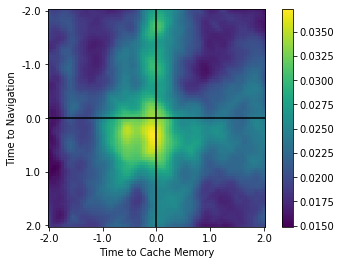

In [24]:
# Plot heatmap
window_size = all_overlap_matrices.shape[0]
window_ticks = np.arange(0, window_size, window_size//4)
plt.imshow(all_overlap_matrices)
plt.yticks(window_ticks, (window_ticks-window_size//2)/20)
plt.xticks(window_ticks, (window_ticks-window_size//2)/20)
plt.axhline(window_size//2, color="black")
plt.axvline(window_size//2, color="black")
plt.ylabel("Time to Navigation")
plt.xlabel("Time to Cache Memory")
plt.colorbar()
plt.show()

In [ ]:
plot_overlaps(all_max_overlaps, "Cache vs Navigation")